Import Packages

Import Libraries

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, recall_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA

Load Data

In [288]:
# Load dataset
path = r'datasets/bank-additional-full.csv'
bank = pd.read_csv(path, sep=';', index_col=False, low_memory=False)
y = pd.get_dummies(bank['y'], columns = ['y'], drop_first = True)
yA = y

 Related with the last contact of the current campaign

In [289]:
bank_client = bank.iloc[: , 0:7]
bank_client.head()

,age,job,marital,education,default,housing,loan
0,56,housemaid,married,basic.4y,no,no,no
1,57,services,married,high.school,unknown,no,no
2,37,services,married,high.school,no,yes,no
3,40,admin.,married,basic.6y,no,no,no
4,56,services,married,high.school,no,no,yes


 CONVERT COLUMNS TO CONTINUOUS

In [290]:
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
bank_client['job']      = labelencoder_X.fit_transform(bank_client['job']) 
bank_client['marital']  = labelencoder_X.fit_transform(bank_client['marital']) 
bank_client['education']= labelencoder_X.fit_transform(bank_client['education']) 
bank_client['default']  = labelencoder_X.fit_transform(bank_client['default']) 
bank_client['housing']  = labelencoder_X.fit_transform(bank_client['housing']) 
bank_client['loan']     = labelencoder_X.fit_transform(bank_client['loan']) 

In [291]:
def age(dataframe):
    dataframe.loc[dataframe['age'] <= 32, 'age'] = 1
    dataframe.loc[(dataframe['age'] > 32) & (dataframe['age'] <= 47), 'age'] = 2
    dataframe.loc[(dataframe['age'] > 47) & (dataframe['age'] <= 70), 'age'] = 3
    dataframe.loc[(dataframe['age'] > 70) & (dataframe['age'] <= 98), 'age'] = 4
           
    return dataframe

age(bank_client);

In [292]:
bank_client.head()

,age,job,marital,education,default,housing,loan
0,3,3,1,0,0,0,0
1,3,7,1,3,1,0,0
2,2,7,1,3,0,2,0
3,2,0,1,1,0,0,0
4,3,7,1,3,0,0,2


In [293]:
bank_related = bank.iloc[: , 7:11]
bank_related.head()

,contact,month,day_of_week,duration
0,telephone,may,mon,261
1,telephone,may,mon,149
2,telephone,may,mon,226
3,telephone,may,mon,151
4,telephone,may,mon,307


In [294]:
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
bank_related['contact']     = labelencoder_X.fit_transform(bank_related['contact']) 
bank_related['month']       = labelencoder_X.fit_transform(bank_related['month']) 
bank_related['day_of_week'] = labelencoder_X.fit_transform(bank_related['day_of_week']) 

In [295]:
def duration(data):

    data.loc[data['duration'] <= 102, 'duration'] = 1
    data.loc[(data['duration'] > 102) & (data['duration'] <= 180)  , 'duration']    = 2
    data.loc[(data['duration'] > 180) & (data['duration'] <= 319)  , 'duration']   = 3
    data.loc[(data['duration'] > 319) & (data['duration'] <= 644.5), 'duration'] = 4
    data.loc[data['duration']  > 644.5, 'duration'] = 5

    return data
duration(bank_related);

In [296]:
bank_related.head()

,contact,month,day_of_week,duration
0,1,6,1,3
1,1,6,1,2
2,1,6,1,3
3,1,6,1,2
4,1,6,1,3


In [297]:
bank_se = bank.loc[: , ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]
bank_se.head()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.1,93.994,-36.4,4.857,5191.0
1,1.1,93.994,-36.4,4.857,5191.0
2,1.1,93.994,-36.4,4.857,5191.0
3,1.1,93.994,-36.4,4.857,5191.0
4,1.1,93.994,-36.4,4.857,5191.0


In [298]:
bank_o = bank.loc[: , ['campaign', 'pdays','previous', 'poutcome']]
bank_o.head()

,campaign,pdays,previous,poutcome
0,1,999,0,nonexistent
1,1,999,0,nonexistent
2,1,999,0,nonexistent
3,1,999,0,nonexistent
4,1,999,0,nonexistent


In [299]:
bank_o['poutcome'].replace(['nonexistent', 'failure', 'success'], [1,2,3], inplace  = True)

Model, Imbalance Dataset, ROC, Evaluate

In [300]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import resample

IMBALANCED DATASET FIX

In [301]:
bank_final= pd.concat([bank_client, bank_related, bank_se, bank_o], axis = 1)
bank_final = bank_final[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
                     'contact', 'month', 'day_of_week', 'duration', 'emp.var.rate', 'cons.price.idx', 
                     'cons.conf.idx', 'euribor3m', 'nr.employed', 'campaign', 'pdays', 'previous', 'poutcome']]
bank_final.shape

(41188, 20)

In [302]:
bank_final1 = pd.concat([bank_final, y], axis = 1)
df_majority = bank_final1[bank_final1['yes'] == 0]
df_minority = bank_final1[bank_final1['yes'] == 1]

In [303]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples= int(4640*2),    
                                 random_state=123) 

In [304]:
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
y_new = df_upsampled['yes']

Train Test DATASET FIX

In [305]:
X_train, X_test, y_train, y_test = train_test_split(df_upsampled.drop('yes', axis = 1), y_new, test_size = 0.1942313295, random_state = 101)
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

StandardScaler

In [306]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

 Random Forest Classifier

In [307]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 200, n_jobs=2, random_state = 12)#criterion = entopy,gini
rfc.fit(X_train, y_train)
rfcpred = rfc.predict(X_test)
RFCCV = (cross_val_score(rfc, X_train, y_train, cv=k_fold, n_jobs=2, scoring = 'accuracy').mean())

In [308]:
models = pd.DataFrame({
                'Models': ['Random Forest Classifier'],
                'Score':  [RFCCV]})

models.sort_values(by='Score', ascending=False)

,Models,Score
0,Random Forest Classifier,0.937632


ROC CURVE

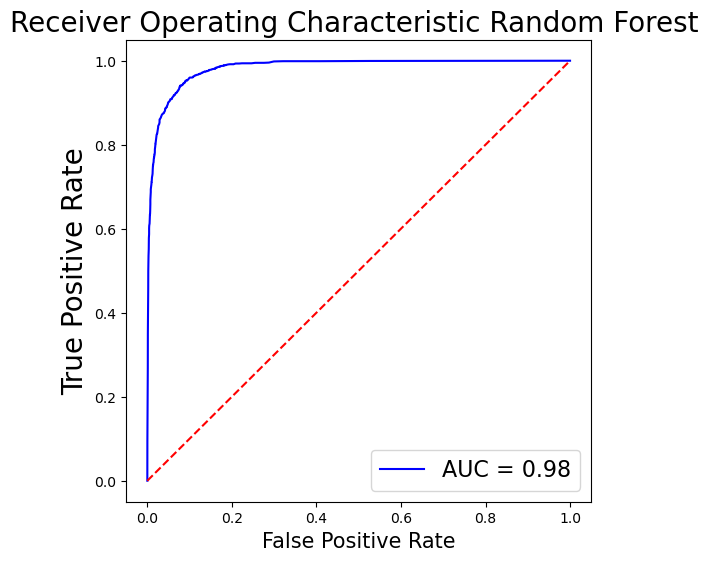

In [309]:
from sklearn import metrics
fig, ax = plt.subplots(figsize = (6,6))
probs = rfc.predict_proba(X_test)
preds = probs[:,1]
fprrfc, tprrfc, thresholdrfc = metrics.roc_curve(y_test, preds)
roc_aucrfc = metrics.auc(fprrfc, tprrfc)

ax.plot(fprrfc, tprrfc, 'b', label = 'AUC = %0.2f' % roc_aucrfc)
ax.plot([0, 1], [0, 1],'r--')
ax.set_title('Receiver Operating Characteristic Random Forest ',fontsize=20)
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.legend(loc = 'lower right', prop={'size': 16})

plt.subplots_adjust(wspace=1)

In [311]:
print('Cross Validation mean: ', (cross_val_score(rfc, X_train, y_train, cv=k_fold, n_jobs=2, scoring = 'accuracy').mean()))


Cross Validation mean:  0.9376319551586425


In [312]:
print('Cross Validation values: ', cross_val_score(rfc, X_train, y_train, cv=k_fold, n_jobs=2, scoring = 'accuracy'))

Cross Validation values:  [0.94205253 0.92959653 0.94448957 0.93961549 0.93338749 0.93907392
 0.937974   0.93959913 0.92930661 0.94122427]


In [313]:
print('RFC Confusion Matrix\n', confusion_matrix(y_test, rfcpred))

RFC Confusion Matrix
 [[6737  367]
 [ 175 1623]]


In [314]:
print('RFC Reports\n',classification_report(y_test, rfcpred))

RFC Reports
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      7104
           1       0.82      0.90      0.86      1798

    accuracy                           0.94      8902
   macro avg       0.90      0.93      0.91      8902
weighted avg       0.94      0.94      0.94      8902



In [315]:
print('RFC Confusion Matrix\n', confusion_matrix(y_test, rfcpred))

RFC Confusion Matrix
 [[6737  367]
 [ 175 1623]]


In [316]:
print('Specificity/ Recall 0 : ', round(6739 /(6739 + 365),2))

Specificity/ Recall 0 :  0.95


In [317]:
print('Sensitivity/ Recall 1 : ',round(1623 / (1623 + 175),3))
print('Sensitivity/ Recall 1 : ',round(metrics.recall_score(y_test, rfcpred),2))

Sensitivity/ Recall 1 :  0.903
Sensitivity/ Recall 1 :  0.9


In [318]:
print('RFC Confusion Matrix\n', confusion_matrix(y_test, rfcpred))

RFC Confusion Matrix
 [[6737  367]
 [ 175 1623]]


In [320]:
print('Precision 0 : ',round(6739 / (6737 + 175),2))

Precision 0 :  0.97


In [321]:
print('Precision 1 : ',round(1623 / (1623 + 365),2))
print('Precision 1 : ',round(metrics.precision_score(y_test, rfcpred),2))

Precision 1 :  0.82
Precision 1 :  0.82


In [322]:
F1_0 = 2*0.97*0.95/(0.97+0.95)
print('F1-Score 0: ',round(F1_0,2))

F1-Score 0:  0.96


In [323]:
F1_1 = 2*0.82*0.9/(0.82+0.9)
print('F1-Score 1: ',round(F1_1,2))

F1-Score 1:  0.86
